# Quantum computing and its applications series: Qiskit Machine Learning Survey


https://qiskit-community.github.io/qiskit-machine-learning/tutorials/02_neural_network_classifier_and_regressor.html

## 1st Model: Classification

As an example of a quantum model, we'll train a Variational Quantum Classifier (VQC). The VQC is the simplest classifier available in Qiskit Machine Learning and is a good starting point for newcomers to quantum machine learning who have a background in classical machine learning.
First try, Let's import necessary libraries and set Algorithm's global seed value.

1st Try

In [1]:
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms import VQC
from qiskit_machine_learning.datasets import ad_hoc_data

seed = 1376
algorithm_globals.random_seed = seed

In [2]:
# Use ad hoc data set for training and test data
feature_dim = 2  # dimension of each data point
training_size = 20
test_size = 10

# training features, training labels, test features, test labels as np.ndarray,
# one hot encoding for labels
training_features, training_labels, test_features, test_labels = ad_hoc_data(
    training_size=training_size, test_size=test_size, n=feature_dim, gap=0.3
)

In [3]:
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear")
ansatz = TwoLocal(feature_map.num_qubits, ["ry", "rz"], "cz", reps=3)

vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=100),
)

In [4]:
vqc.fit(training_features, training_labels)

In [6]:
score = vqc.score(test_features, test_labels)
print(f"Testing accuracy: {score:0.2f}")

Testing accuracy: 0.95


c:\Users\USER\anaconda3\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:282: UserWarning: Style JSON file 'clifford.json' not found in any of these locations: c:\Users\USER\anaconda3\lib\site-packages\qiskit\visualization\circuit\styles\clifford.json, clifford.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


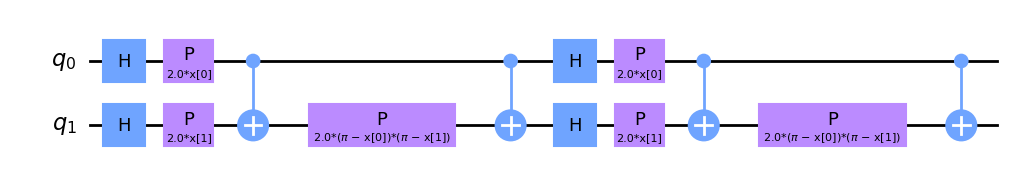

In [7]:
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

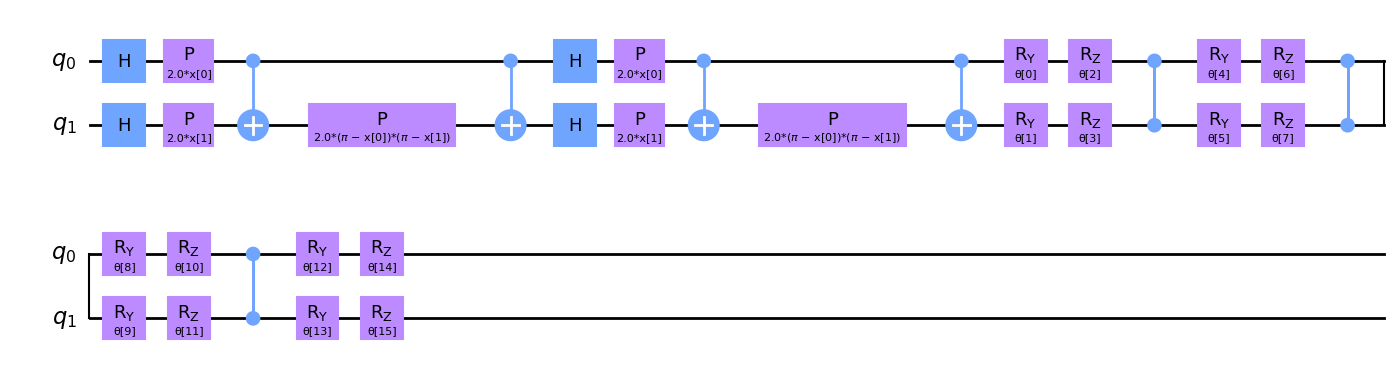

In [8]:
vqc.circuit.decompose().draw(output="mpl", style="clifford", fold=20)

## Perform a classification task on the toy dataset

In [25]:
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

import matplotlib.pyplot as plt
import numpy as np

algorithm_globals.random_seed = 42

Create and visualize toy dataset.

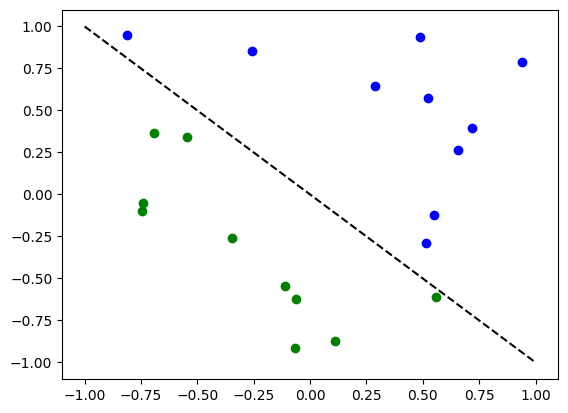

In [10]:
num_inputs = 2
num_samples = 20
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2 * y01 - 1  # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

## 1.1 Classification with an EstimatorQNN

The EstimatorQNN is expected to return one-dimensional output in [−1,+1]. This only works for binary classification and we assign the two classes to {−1,+1}.

c:\Users\USER\anaconda3\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:282: UserWarning: Style JSON file 'clifford.json' not found in any of these locations: c:\Users\USER\anaconda3\lib\site-packages\qiskit\visualization\circuit\styles\clifford.json, clifford.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


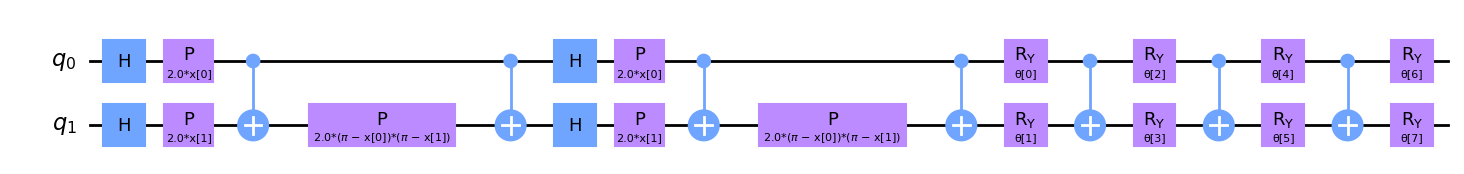

In [11]:
# construct QNN with the QNNCircuit's default ZZFeatureMap feature map and RealAmplitudes ansatz.
qc = QNNCircuit(num_qubits=2)
qc.decompose().draw("mpl", style="clifford")

In [12]:
estimator_qnn = EstimatorQNN(circuit=qc)

# QNN maps inputs to [-1, +1]
estimator_qnn.forward(X[0, :], algorithm_globals.random.random(estimator_qnn.num_weights))

array([[0.23521988]])

Define callback function that draws a live plot when the .fit() method is called.

In [13]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

Define neural network classifier.

In [14]:
# construct neural network classifier
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph
)

Training the model.

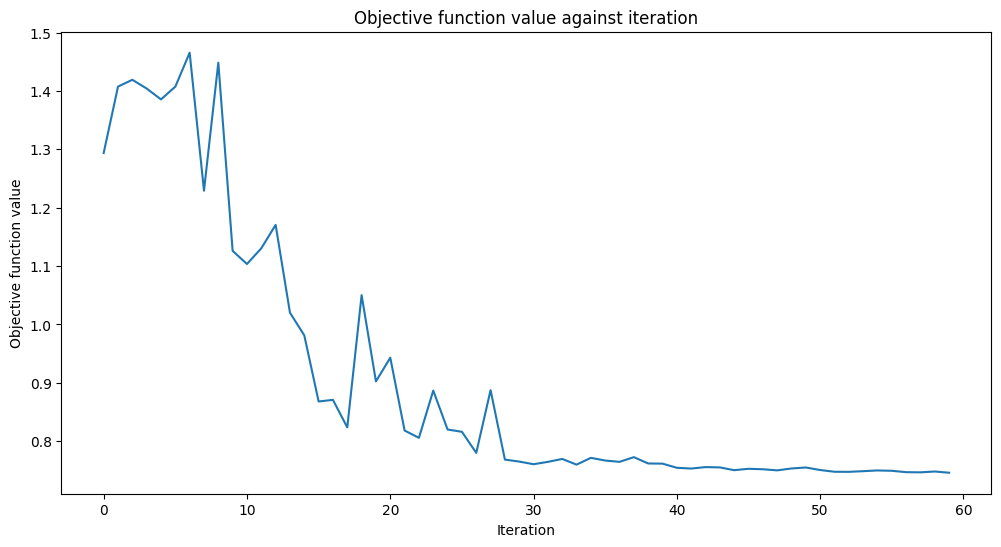

0.8

In [15]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
estimator_classifier.score(X, y)

Evaluate model and plot results.

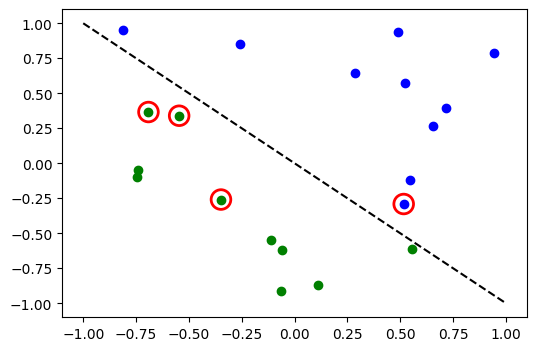

In [16]:
# evaluate data points
y_predict = estimator_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

Checking model's weights.

In [17]:
estimator_classifier.weights

array([ 0.86209107, -1.06526254, -0.10663602, -0.39086371,  1.0894299 ,
        0.59368219,  2.22731471, -1.04769663])

## 1.2 Classification with a SamplerQNN

The SamplerQNN is expected to return d-dimensional probability vector as output, where d denotes the number of classes.

Define a quantum circuit.

c:\Users\USER\anaconda3\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:282: UserWarning: Style JSON file 'clifford.json' not found in any of these locations: c:\Users\USER\anaconda3\lib\site-packages\qiskit\visualization\circuit\styles\clifford.json, clifford.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


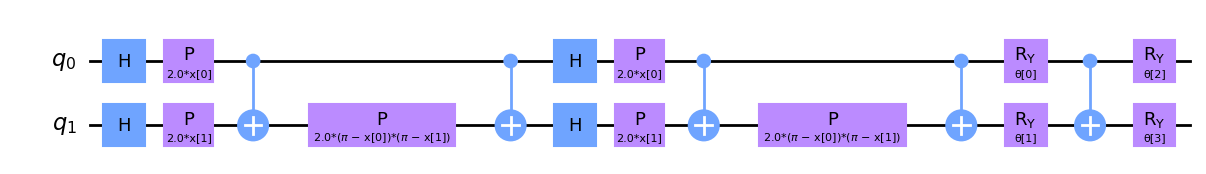

In [24]:
# construct a quantum circuit from the default ZZFeatureMap feature map and a customized RealAmplitudes ansatz
qc = QNNCircuit(ansatz=RealAmplitudes(num_inputs, reps=1))
qc.decompose().draw("mpl", style="clifford")

Define parity function and declare output shape

In [19]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

Create model

In [20]:
# construct QNN
sampler_qnn = SamplerQNN(
    circuit=qc,
    interpret=parity,
    output_shape=output_shape,
)

In [21]:
# construct classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=COBYLA(maxiter=30), callback=callback_graph
)

Training the model.

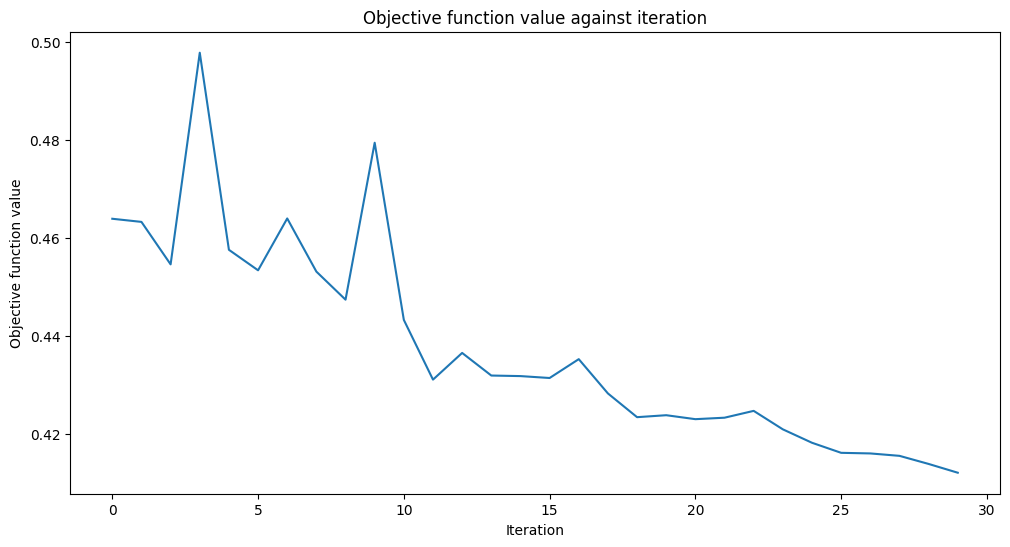

0.7

In [22]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier.fit(X, y01)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
sampler_classifier.score(X, y01)

Again, Evaluate model and plot results.

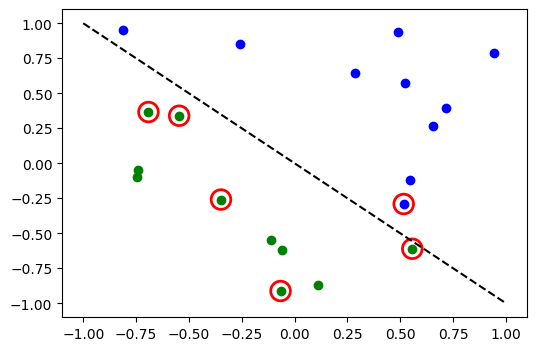

In [23]:
# evaluate data points
y_predict = sampler_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

## 1.3 Classification with Variational Quantum Classifier (VQC)

The VQC is a special variant of the NeuralNetworkClassifier with a SamplerQNN. It applies a parity mapping (or extensions to multiple classes) to map from the bitstring to the classification, which results in a probability vector, which is interpreted as a one-hot encoded result. By default, it applies this the CrossEntropyLoss function that expects labels given in one-hot encoded format and will return predictions in that format too.

In [26]:
# construct feature map, ansatz, and optimizer
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct variational quantum classifier
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph,
)

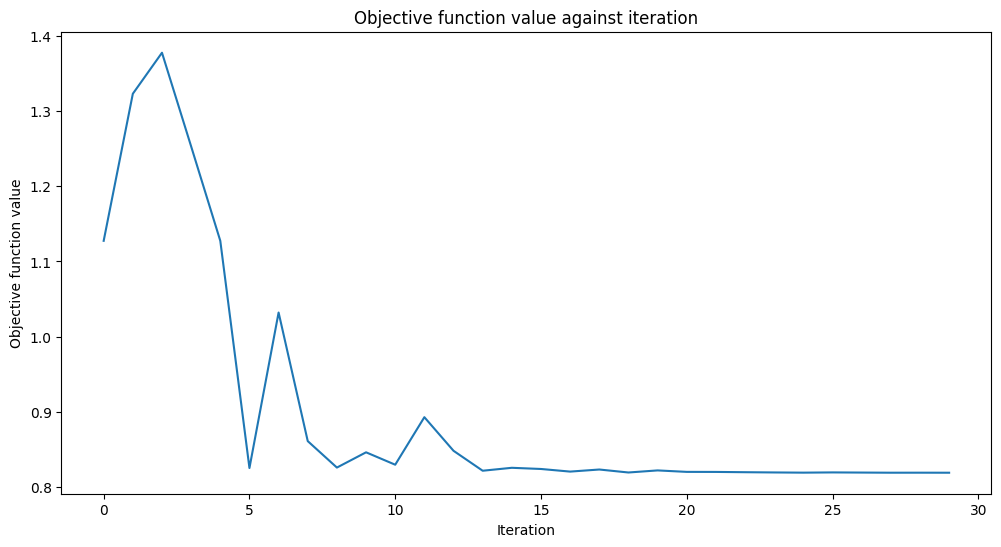

0.75

In [27]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X, y_one_hot)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X, y_one_hot)

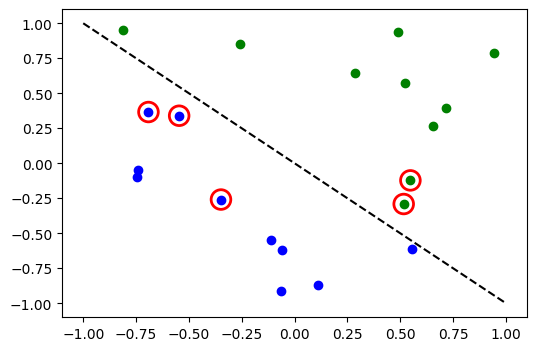

In [28]:
# evaluate data points
y_predict = vqc.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y_one_hot, y_predict):
    if y_target[0] == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

## 1.4 Multiple classes with VQC

In this section we generate an artificial dataset that contains samples of three classes and show how to train a model to classify this dataset. 

In [29]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler

X, y = make_classification(
    n_samples=10,
    n_features=2,
    n_classes=3,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=2.0,
    random_state=algorithm_globals.random_seed,
)
X = MinMaxScaler().fit_transform(X)

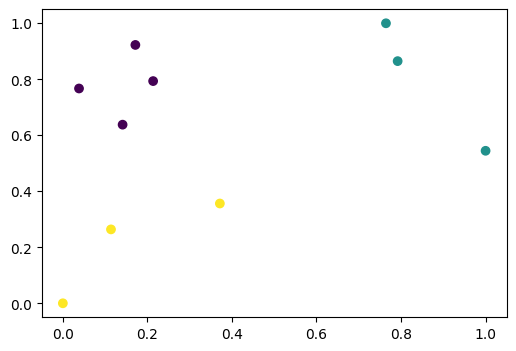

In [30]:
plt.scatter(X[:, 0], X[:, 1], c=y)

Let's transform labels and make them categorical.

In [31]:
y_cat = np.empty(y.shape, dtype=str)
y_cat[y == 0] = "A"
y_cat[y == 1] = "B"
y_cat[y == 2] = "C"
print(y_cat)

['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'C']


Then we create an instance of VQC similar to the previous example, but in this case we pass a minimal set of parameters. Instead of feature map and ansatz we pass just the number of qubits that is equal to the number of features in the dataset, an optimizer with a low number of iteration to reduce training time, a quantum instance, and a callback to observe progress.

In [32]:
vqc = VQC(
    num_qubits=2,
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph,
)

Training the model.

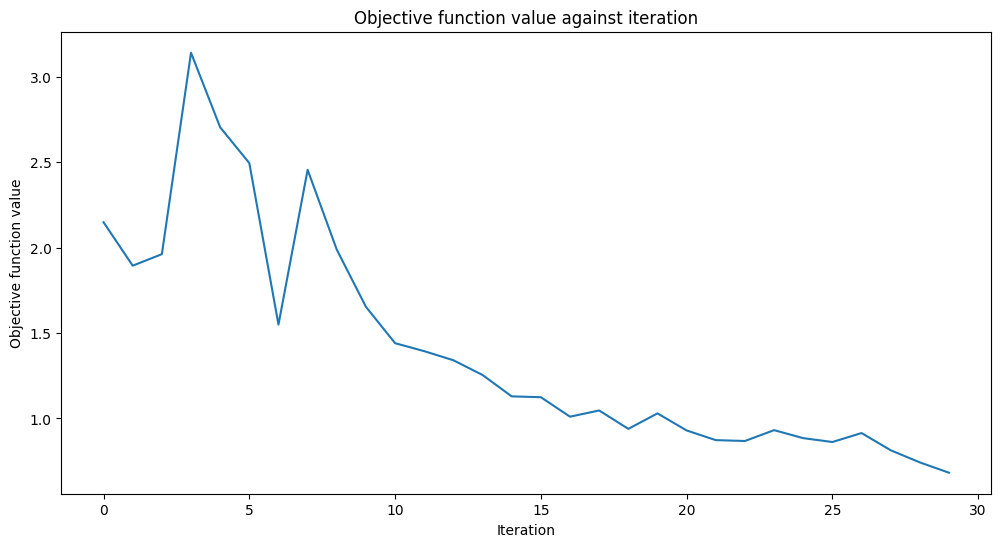

0.9

In [33]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X, y_cat)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X, y_cat)

Make a prediction.

In [34]:
predict = vqc.predict(X)
print(f"Predicted labels: {predict}")
print(f"Ground truth:     {y_cat}")

Predicted labels: ['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'B']
Ground truth:     ['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'C']


## 2nd Model: Regression

Let's prepare a simple regression dataset to illustrate the following algorithms.

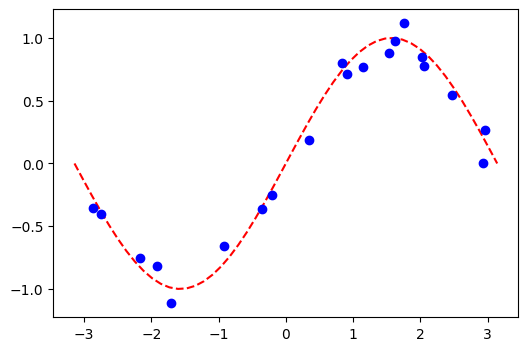

In [35]:
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
X_ = np.linspace(lb, ub, num=50).reshape(50, 1)
f = lambda x: np.sin(x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X[:, 0]) + eps * (2 * algorithm_globals.random.random(num_samples) - 1)

plt.plot(X_, f(X_), "r--")
plt.plot(X, y, "bo")
plt.show()

## 2.1 Regression with an EstimatorQNN

Regression with an EstimatorQNN that returns values in [−1,+1]. More complex and also multi-dimensional models could be constructed, also based on SamplerQNN.

In [36]:
# construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# construct simple ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

# construct a circuit
qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)

# construct QNN
regression_estimator_qnn = EstimatorQNN(circuit=qc)

In [37]:
# construct the regressor from the neural network
regressor = NeuralNetworkRegressor(
    neural_network=regression_estimator_qnn,
    loss="squared_error",
    optimizer=L_BFGS_B(maxiter=5),
    callback=callback_graph,
)

Training the model.

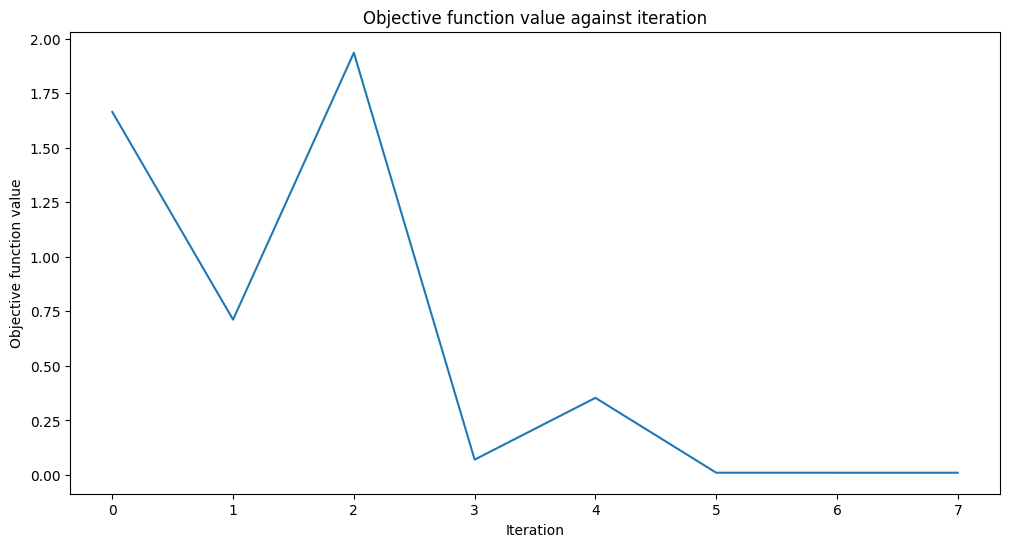

0.9772173064725396

In [38]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score the result
regressor.score(X, y)

Make a prediction.

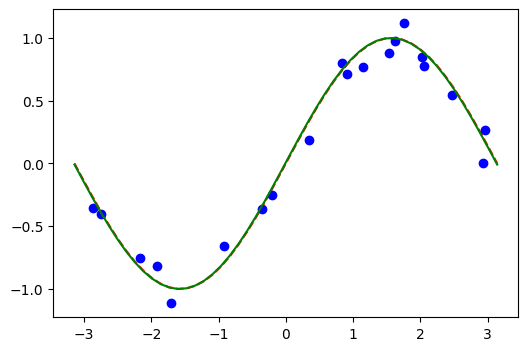

In [39]:
# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = regressor.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()

In [40]:
regressor.weights

array([-1.56208847])

## 2.2 Regression with the Variational Quantum Regressor (VQR)

Similar to the VQC for classification, the VQR is a special variant of the NeuralNetworkRegressor with a EstimatorQNN. By default it considers the L2Loss function to minimize the mean squared error between predictions and targets.

In [41]:
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(maxiter=5),
    callback=callback_graph,
)

Training the model.

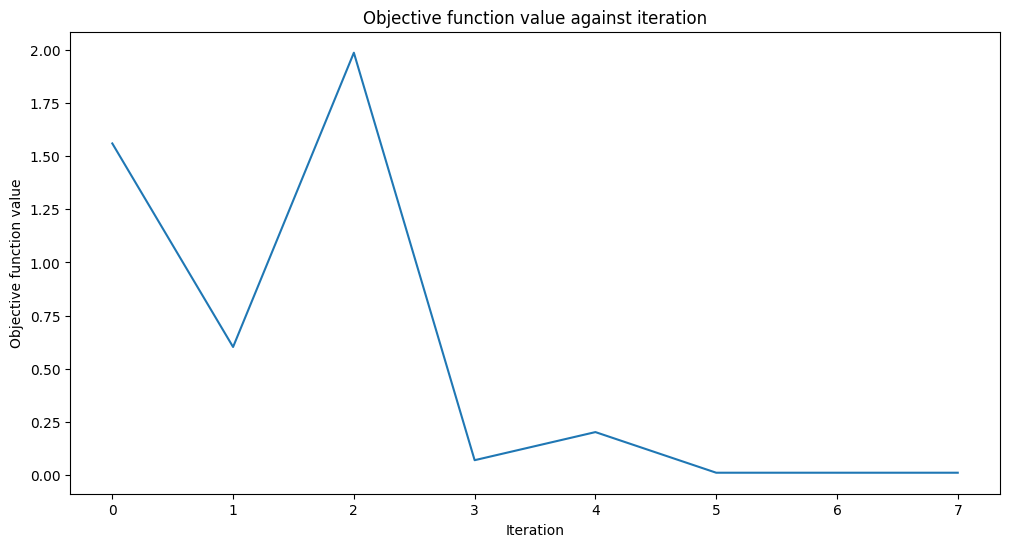

0.9772173064725832

In [42]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score result
vqr.score(X, y)

Make a prediction.

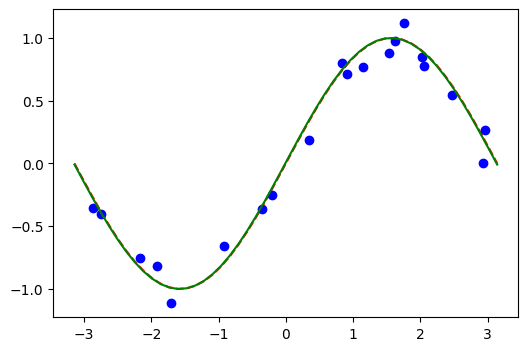

In [43]:
# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = vqr.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()